In [1]:
%load_ext autoreload
%autoreload 2

import os
import gc
import time
import numpy as np; np.random.seed(42)
import pandas as pd
import lightgbm as lgb
import category_encoders as ce
import matplotlib.pyplot as plt

from tsforest.forecaster import LightGBMForecaster
from tsforest.utils import make_time_range
from tsforest.metrics import compute_rmse

# local modules
import sys
sys.path.append("../lib/")
from utils import (compute_scaling, compute_weights, reduce_mem_usage, 
                   compute_scales_by_level, compute_weights_by_level)
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator, WRMSSEEvaluatorL12
from encoding import HierarchicalEncoder

def trimean(array, axis=0):
    quantiles = np.percentile(array, [25, 50, 75], axis=axis)
    return (quantiles[0,:] + 2*quantiles[1,:] + quantiles[2,:])/4

SEEDS = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# validation period to be used for test in all this notebook
valid_period = (pd.to_datetime("2016-04-25"), pd.to_datetime("2016-05-22"))

***
# Level 12

In [3]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )
data["sales"] = data.eval("y * sell_price")

scaling_input = pd.read_parquet("../input/scaling_input.parquet")
weighting_input = pd.read_parquet("../input/weighting_input.parquet")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46796220 entries, 0 to 46796219
Data columns (total 44 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ts_id              int16         
 1   item_id            int16         
 2   dept_id            int8          
 3   cat_id             int8          
 4   store_id           int8          
 5   state_id           int8          
 6   y                  int16         
 7   ds                 datetime64[ns]
 8   snap_CA            int8          
 9   snap_TX            int8          
 10  snap_WI            int8          
 11  snap_CA_cum        int8          
 12  snap_TX_cum        int8          
 13  snap_WI_cum        int8          
 14  event_name_1       int8          
 15  event_type_1       int8          
 16  event_name_2       int8          
 17  event_type_2       int8          
 18  sell_price         float32       
 19  n_prices           float32       
 20  regular_price      flo

In [4]:
%%time
scales_by_level = compute_scales_by_level(scaling_input, valid_period[0])
weights_by_level = compute_weights_by_level(weighting_input, valid_period[0])

CPU times: user 1min 41s, sys: 30 s, total: 2min 11s
Wall time: 2min 11s


In [14]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':800,
    #'early_stopping_rounds':300,
    'max_bin': 127,
    'bin_construct_sample_cnt':6000000,
    'num_leaves': 2**10-1,
    'min_data_in_leaf': 2**10-1,
    'learning_rate': 0.05, 
    'feature_fraction': 0.8,
    'bagging_fraction':0.75,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
    'first_metric_only': True,
}

time_features = [
    "year",
    "month",
    #"year_week",
    #"year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    "year_week_cos",
    "year_week_sin",
    #"month_cos",
    #"month_sin"
]

exclude_features = [
    "ts_id",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    
    "prev_newyear",
    "post_newyear",
    "lw_day",
    "lw_type",
    "prev_lw",
    "post_lw",
    "post_christmas",
    "prev_thanksgiving",
    "post_thanksgiving",
    
    "no_stock_days",
    "sales",
]

categorical_features = {
    #"item_id": ("y", ce.GLMMEncoder, None),
    "item_id": "default",
    "store_id": "default",
    "state_id": "default",
    "dept_id": "default",
    "cat_id": "default",
    "event_name_1": "default",
    }

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    #"lags": list(range(1,15)),
    "window_shifts":[1,7,28],
    "window_functions":["mean","std","kurt",],
    "window_sizes":[7,28],
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["item_id","store_id"],
}

lagged_features = list()
if "lags" in model_kwargs.keys():
    lag_features = [f"lag{lag}" for lag in model_kwargs["lags"]]
    lagged_features.extend(lag_features)
if "window_functions" in model_kwargs.keys():
    rw_features = [f"{window_func}{window_size}_shift{window_shift}" 
                   for window_func in model_kwargs["window_functions"]
                   for window_size in model_kwargs["window_sizes"]
                   for window_shift in model_kwargs["window_shifts"]]
    lagged_features.extend(rw_features)
    
lagged_features_to_dropna = list(filter(lambda x: "skew" not in x, lagged_features))
lagged_features_to_dropna = list(filter(lambda x: "kurt" not in x, lagged_features_to_dropna))

***
## training with many seeds

####################################################################################################
 Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) - seed: 2 #
####################################################################################################
Building the features
Elapsed time: 7.379893231391907 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.834972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7179
[LightGBM] [Info] Number of data points in the train set: 44265550, number of used features: 51
Elapsed time: 41.4844729423523 [min]
Predicting
Elapsed time: 8.719914186000825 [min]
wrmsse: 0.5044012729679489
wrmsseL12: 0.8206401297726718
{'root': 0.2142043612078009, ('state_id',): 0.33068636603952906, ('store_id',): 0.4302341182853623, ('cat_id',): 0.30

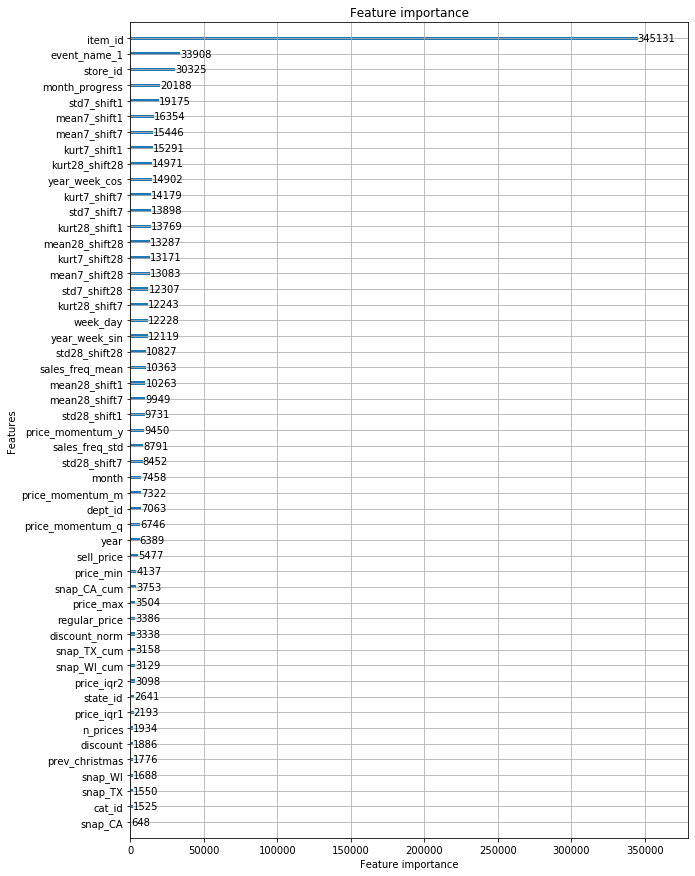

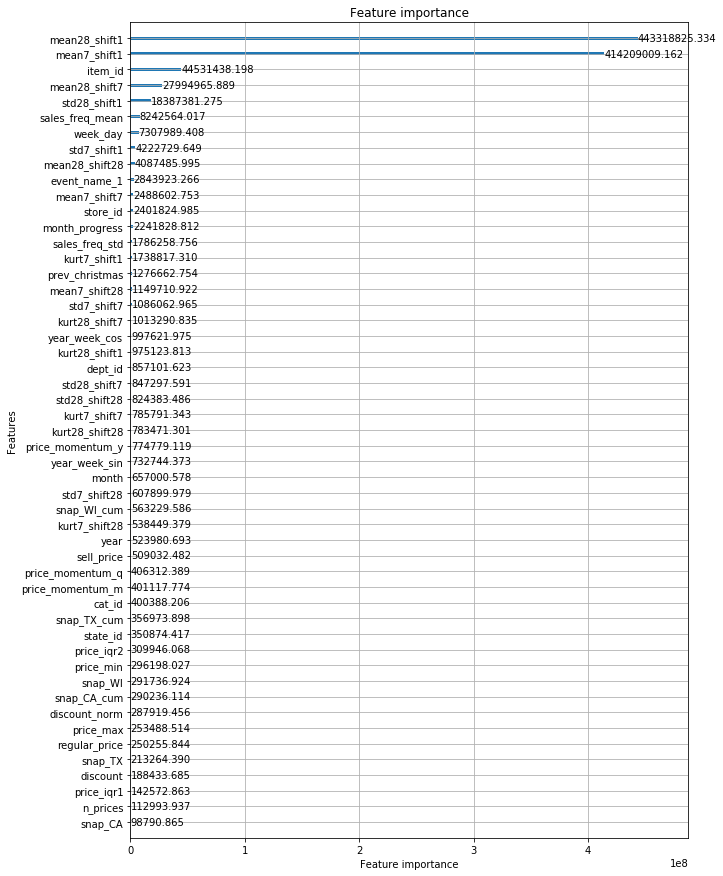

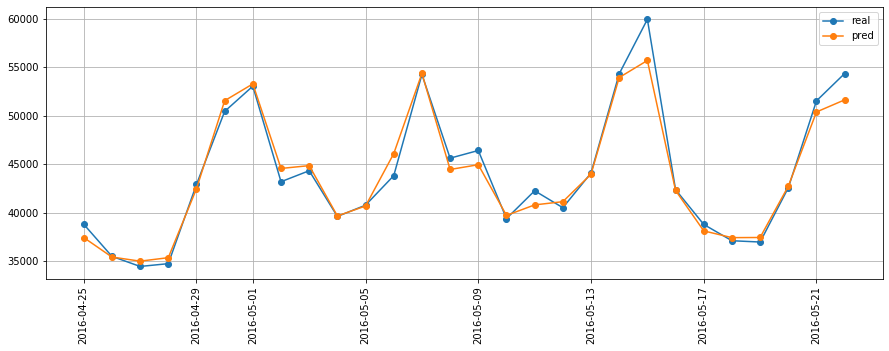

####################################################################################################
 Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) - seed: 3 #
####################################################################################################
Building the features
Elapsed time: 6.40697838862737 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 3.061119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7179
[LightGBM] [Info] Number of data points in the train set: 44265550, number of used features: 51
Elapsed time: 42.03062302668889 [min]
Predicting
Elapsed time: 8.77727727095286 [min]
wrmsse: 0.4992666821702114
wrmsseL12: 0.8205099282933702
{'root': 0.192174026587007, ('state_id',): 0.3165333309080967, ('store_id',): 0.42270995324311345, ('cat_id',): 0.2870

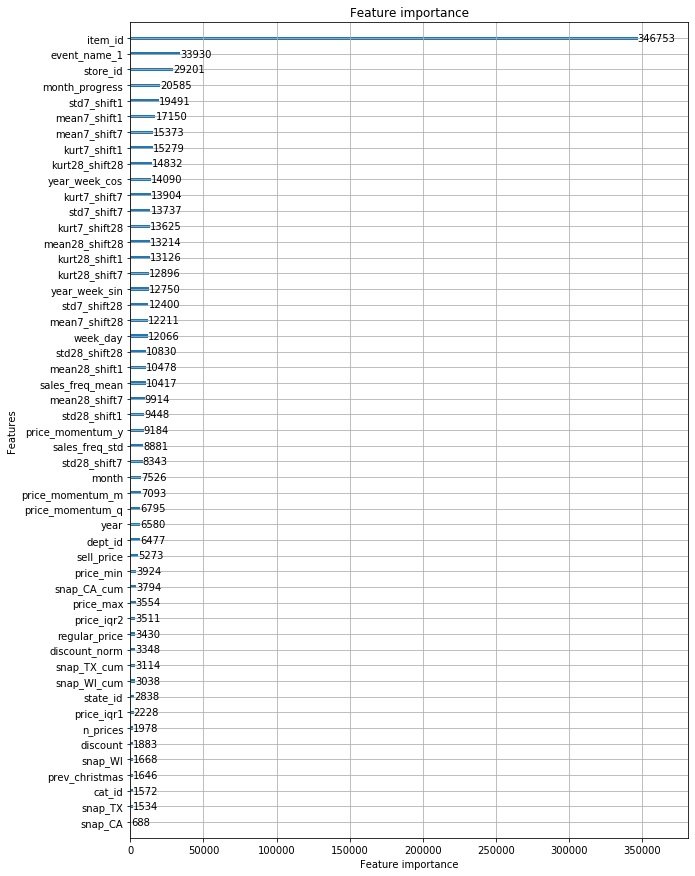

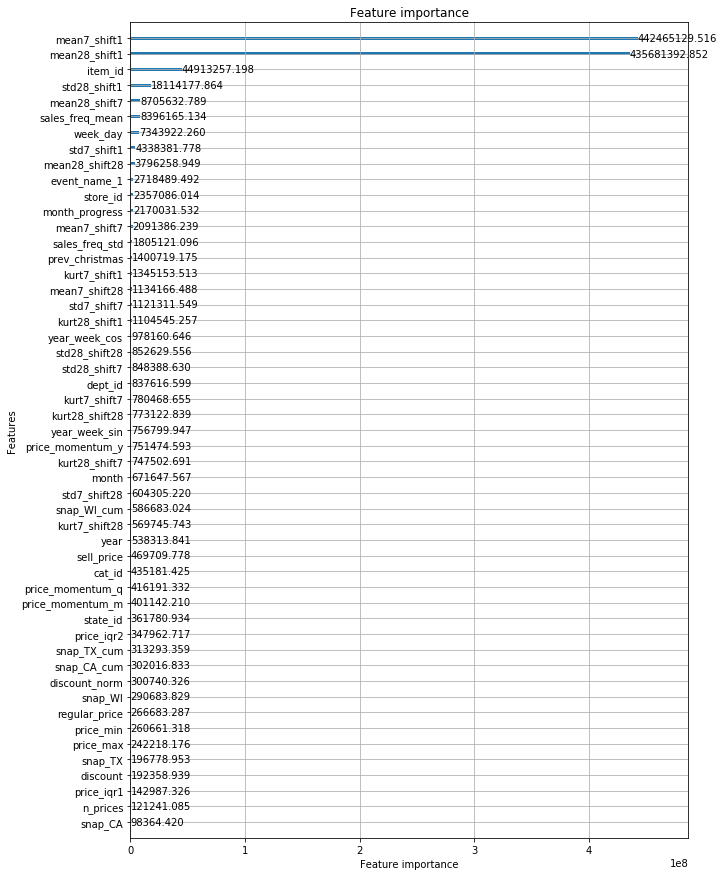

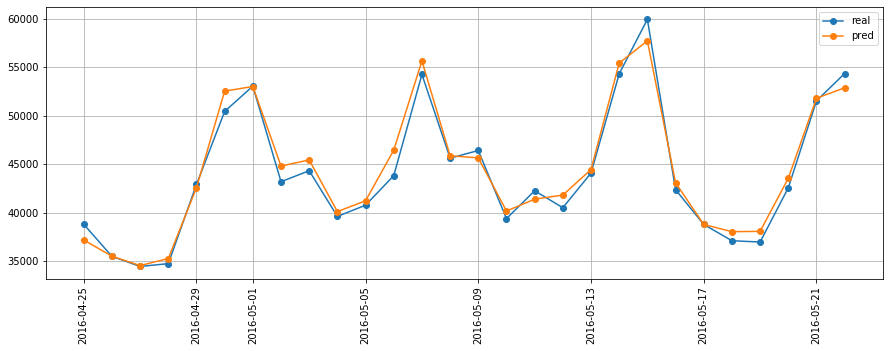

####################################################################################################
 Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) - seed: 5 #
####################################################################################################
Building the features
Elapsed time: 6.563401476542155 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 3.209361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7179
[LightGBM] [Info] Number of data points in the train set: 44265550, number of used features: 51
Elapsed time: 41.67685189247131 [min]
Predicting
Elapsed time: 8.77406363884608 [min]
wrmsse: 0.5030888804781767
wrmsseL12: 0.82215912490268
{'root': 0.20364998412831456, ('state_id',): 0.31683320702587825, ('store_id',): 0.44219041992192387, ('cat_id',): 0.28

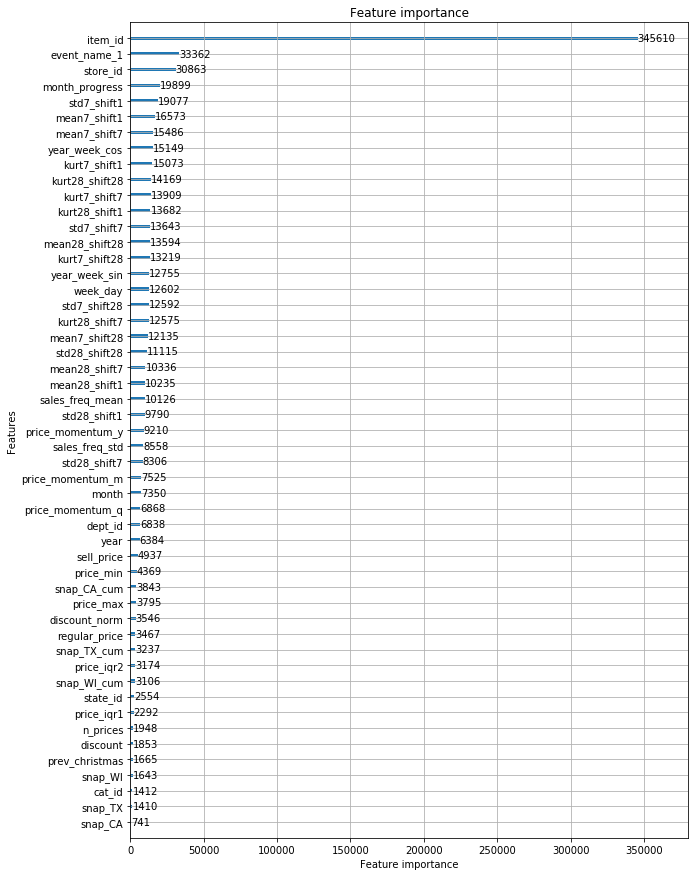

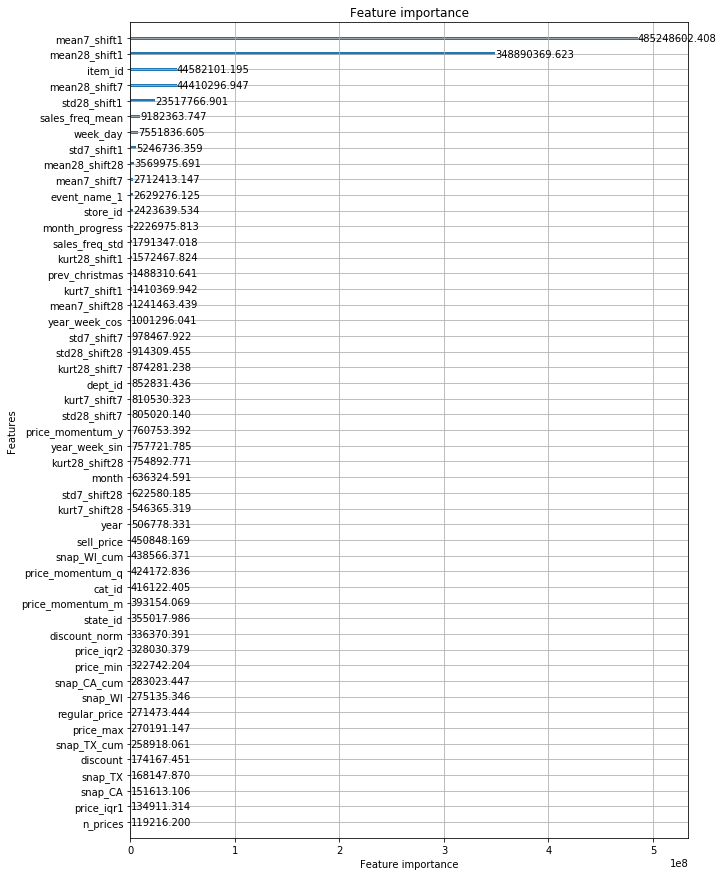

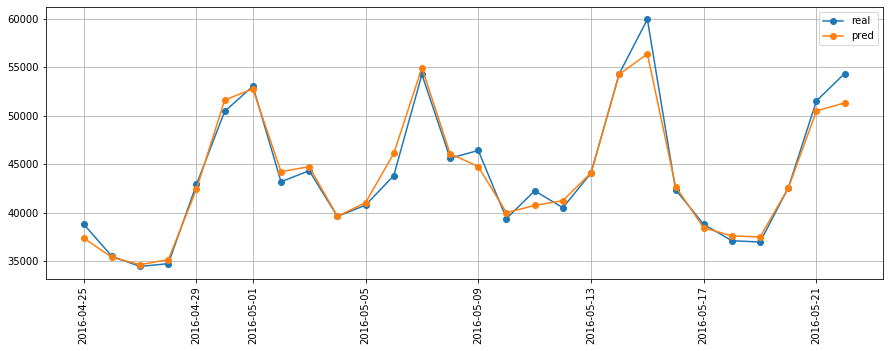

####################################################################################################
 Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) - seed: 7 #
####################################################################################################
Building the features
Elapsed time: 6.626065798600515 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.993721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7179
[LightGBM] [Info] Number of data points in the train set: 44265550, number of used features: 51
Elapsed time: 41.81764676968257 [min]
Predicting
Elapsed time: 8.829883901278178 [min]
wrmsse: 0.5010804760277764
wrmsseL12: 0.8196764061621098
{'root': 0.21533827615332035, ('state_id',): 0.3244418853954339, ('store_id',): 0.4201554564115827, ('cat_id',): 0.2

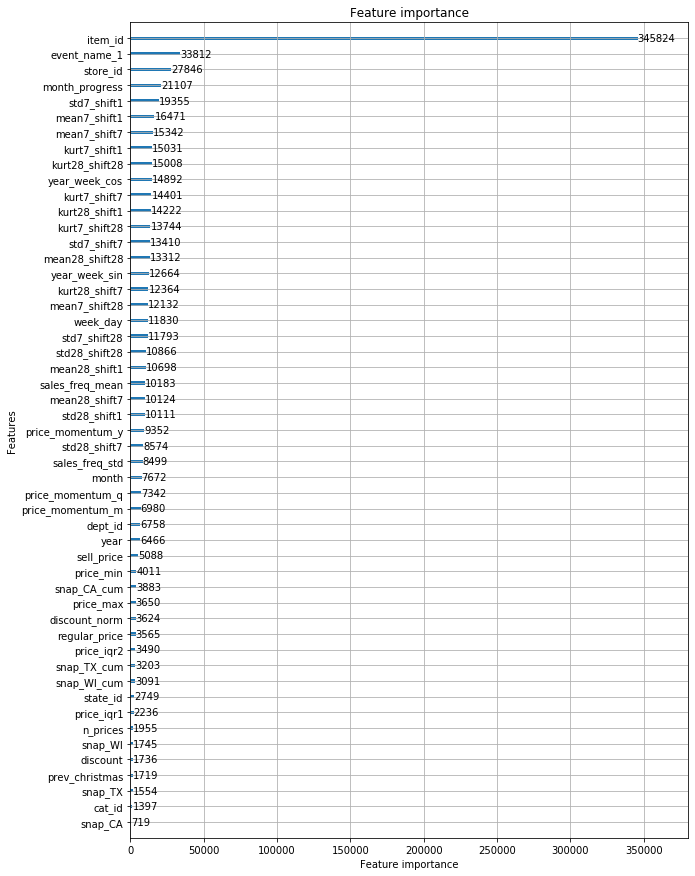

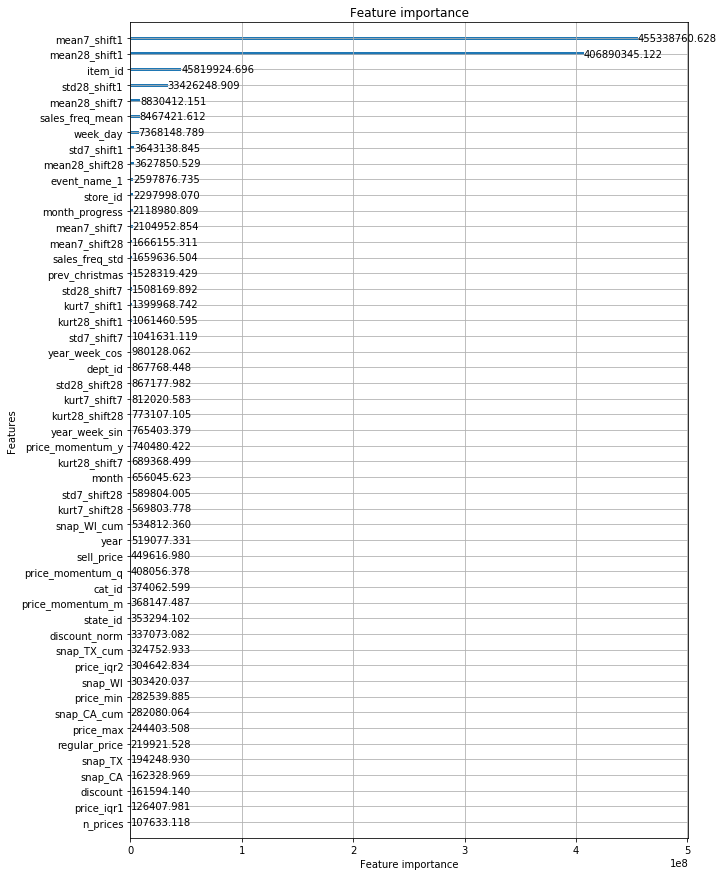

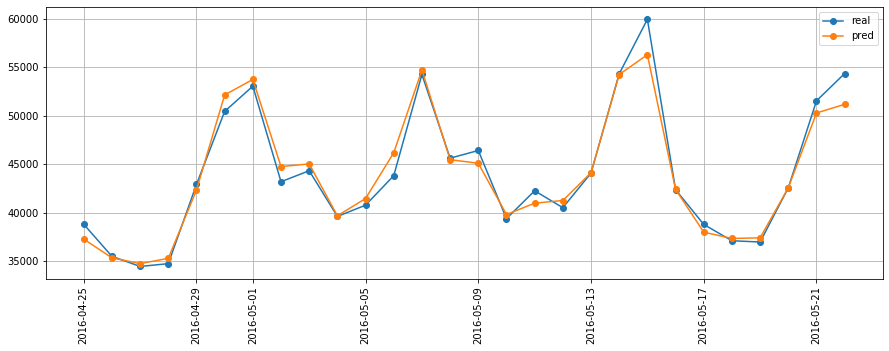

####################################################################################################
 Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) - seed: 11 
####################################################################################################
Building the features
Elapsed time: 6.5279446283976235 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.443330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7179
[LightGBM] [Info] Number of data points in the train set: 44265550, number of used features: 51
Elapsed time: 41.14234162171682 [min]
Predicting
Elapsed time: 8.809351845582325 [min]
wrmsse: 0.5179597049196775
wrmsseL12: 0.8213712047643653
{'root': 0.24018582111596545, ('state_id',): 0.3452770953289486, ('store_id',): 0.45282371159366197, ('cat_id',): 0

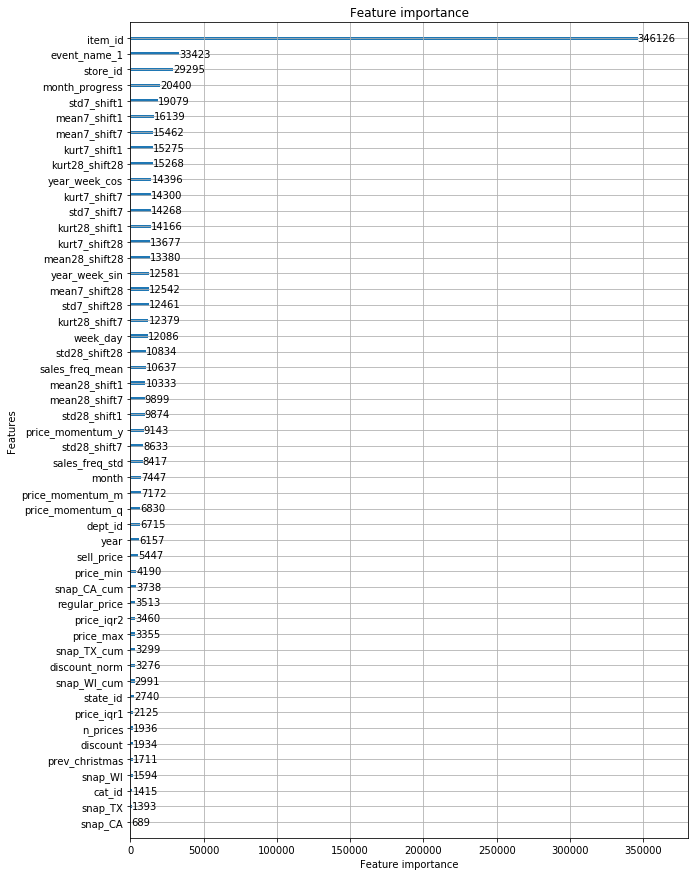

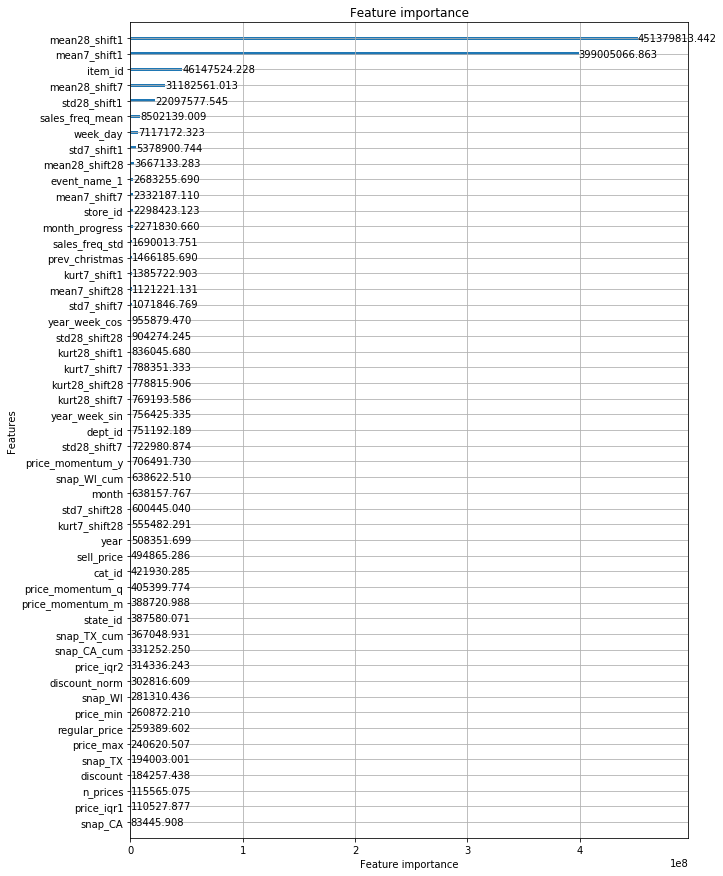

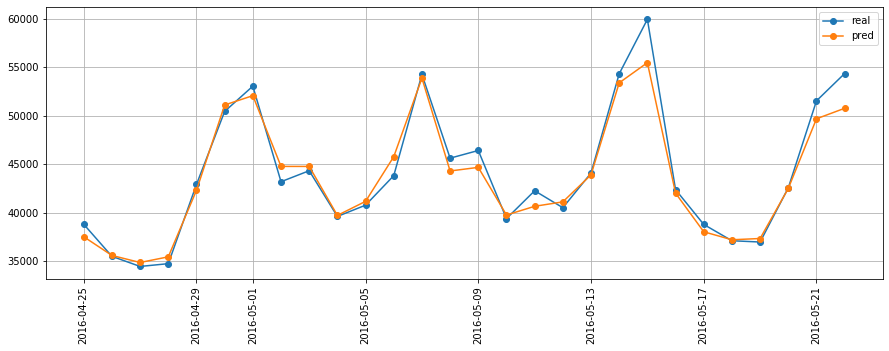

####################################################################################################
 Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) - seed: 13 
####################################################################################################
Building the features
Elapsed time: 6.557626501719157 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.252367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7179
[LightGBM] [Info] Number of data points in the train set: 44265550, number of used features: 51
Elapsed time: 41.788077008724215 [min]
Predicting
Elapsed time: 8.800181245803833 [min]
wrmsse: 0.5089591821574465
wrmsseL12: 0.8203903357892168
{'root': 0.23395644039036162, ('state_id',): 0.3300215373085514, ('store_id',): 0.4302180386969167, ('cat_id',): 0.

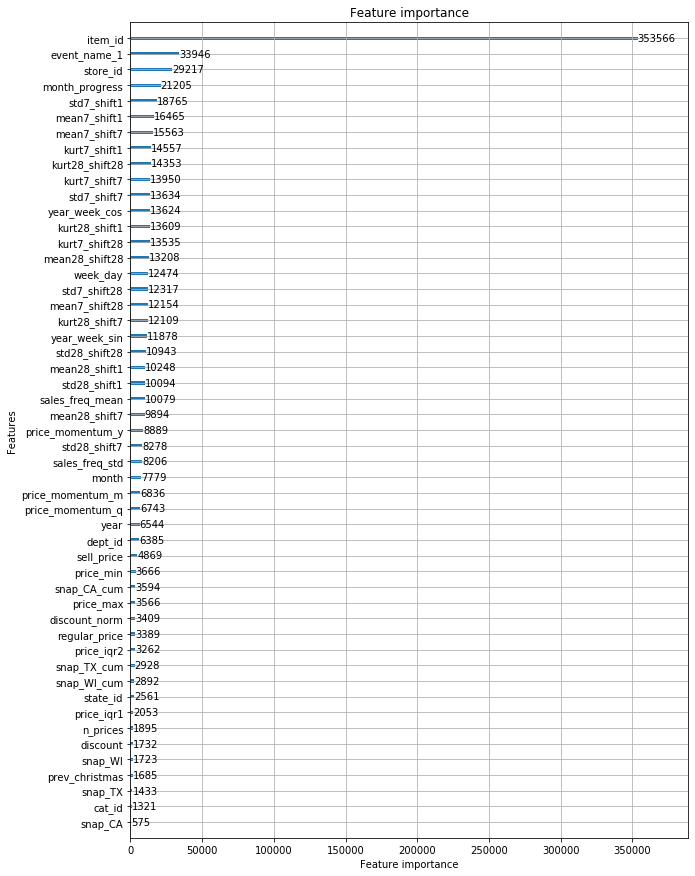

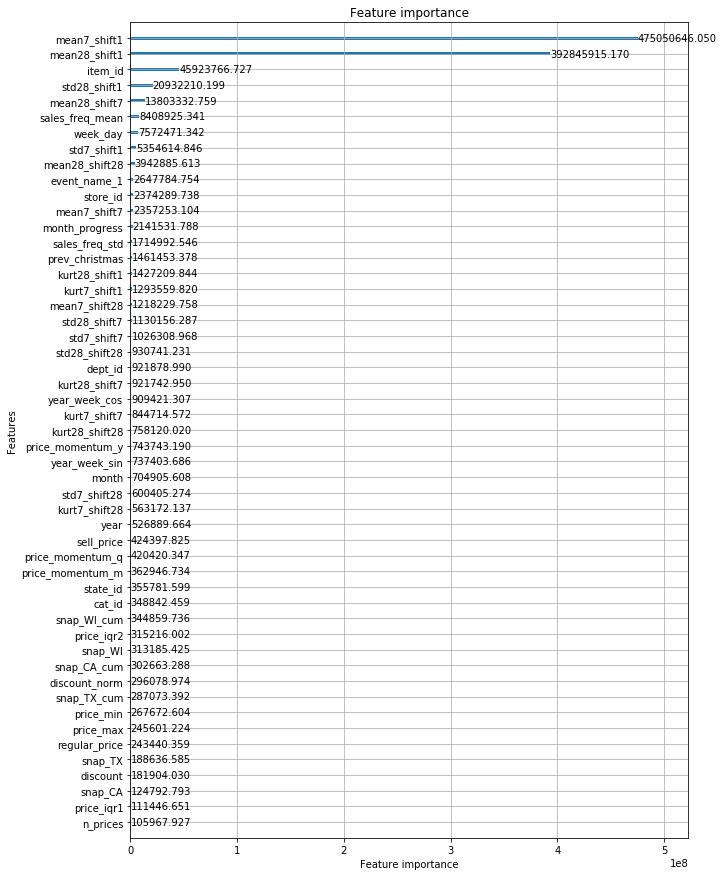

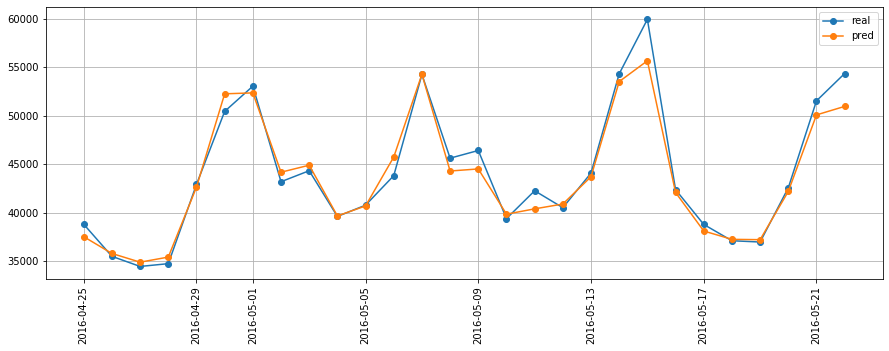

CPU times: user 2d 21h 5min 53s, sys: 8h 49min 40s, total: 3d 5h 55min 34s
Wall time: 5h 44min 44s


In [15]:
%%time
SEEDS = [2,3,5,7,11,13]
forecast_by_fold = list()

for seed in SEEDS:    
    print("#"*100)
    print(f" Validation period: {valid_period} - seed: {seed} ".center(100, "#"))
    print("#"*100)

    valid_start = valid_period[0]
    valid_end = valid_period[1]
    _train_data = data.query("ds < @valid_start").reset_index(drop=True)

    print("Building the features")
    tic = time.time()
    model_kwargs["model_params"]["seed"] = seed
    model_level12 = LightGBMForecaster(**model_kwargs)
    model_level12.prepare_features(train_data=_train_data)
    model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
    model_level12.train_features = reduce_mem_usage(model_level12.train_features)
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")

    ts_id_in_train = model_level12.train_features.ts_id.unique()
    valid_data = data.query("@valid_start <= ds <= @valid_end & ts_id in @ts_id_in_train")
    evaluator = Evaluator(valid_data, weights_by_level, scales_by_level)

    print("Fitting the model")
    tic = time.time()
    model_level12.fit()
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")

    lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,15))
    lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,15))

    print("Predicting")
    tic = time.time()
    forecast = model_level12.predict(valid_data.drop("y", axis=1), recursive=True)
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")

    wrmsse = evaluator.eval1._evaluate(forecast.y_pred.values)
    wrmsseL12 = evaluator.eval2._evaluate(forecast.y_pred.values)
    print("wrmsse:", wrmsse)
    print("wrmsseL12:", wrmsseL12)
    print(evaluator.eval1.errors_by_level)

    mrg = (valid_data.groupby(["ds"])["y"].sum().reset_index()
           .merge(forecast.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
    plt.figure(figsize=(15,5))
    plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
    plt.plot_date(mrg.ds, mrg.y_pred, "o-", label="pred")
    plt.grid()
    plt.xticks(rotation=90)
    plt.legend(loc="best")
    plt.show()

    forecast_by_fold.append(forecast)
    del model_level12, _train_data, valid_data, evaluator
    gc.collect()

***
## training without early stopping

####################################################################################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################
Building the features
Elapsed time: 14.696634443600972 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 5.458699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6137
[LightGBM] [Info] Number of data points in the train set: 43411937, number of used features: 65
Elapsed time: 37.407762841383615 [min]
Predicting
Elapsed time: 14.173004949092865 [min]
wrmsse: 0.5264492352877896
wrmsseL12: 0.8176364412647013
{'root': 0.2898828880183478, ('state_id',): 0.36817933411738535, ('store_id',): 0.4499916319980106, ('cat_id',): 

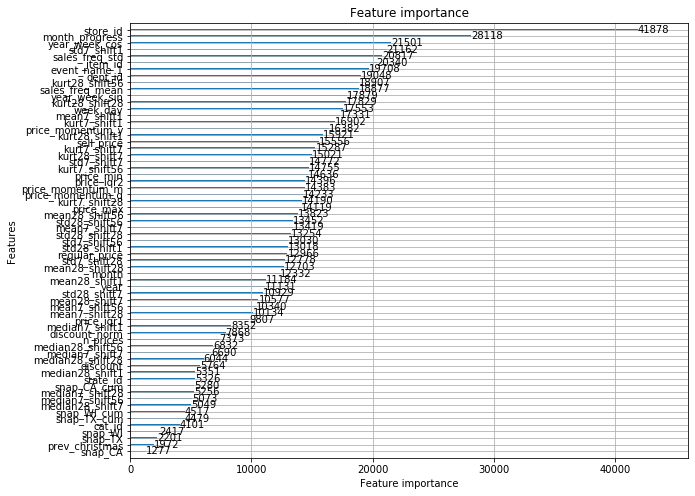

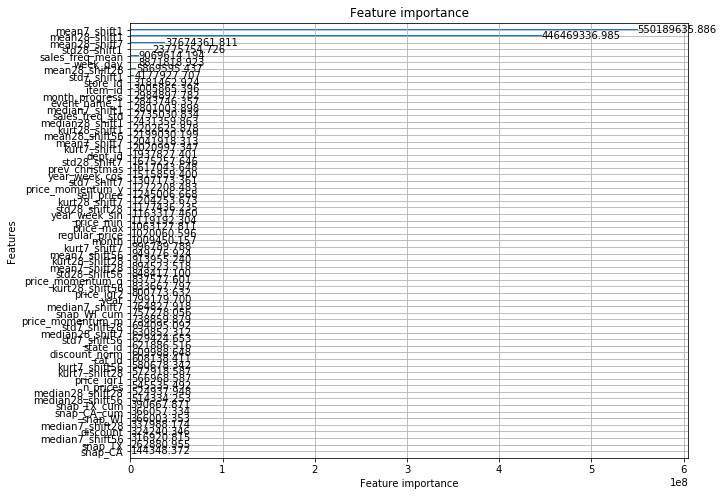

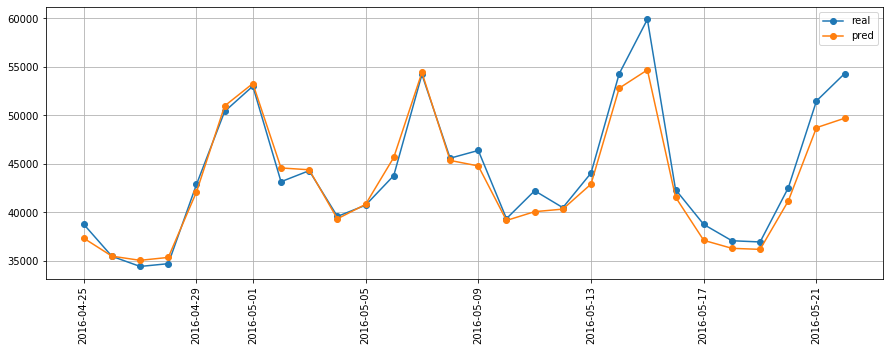

CPU times: user 10h 55min 38s, sys: 1h 33min 45s, total: 12h 29min 23s
Wall time: 1h 6min 31s


30228

In [6]:
%%time 

print("#"*100)
print(f" Validation period: {valid_period} - seed: {seed} ".center(100, "#"))
print("#"*100)

valid_start = valid_period[0]
valid_end = valid_period[1]
_train_data = data.query("ds < @valid_start").reset_index(drop=True)

print("Building the features")
tic = time.time()
model_level12 = LightGBMForecaster(**model_kwargs)
model_level12.prepare_features(train_data=_train_data)
model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
model_level12.train_features = reduce_mem_usage(model_level12.train_features)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

ts_id_in_train = model_level12.train_features.ts_id.unique()
valid_data = data.query("@valid_start <= ds <= @valid_end & ts_id in @ts_id_in_train")
evaluator = Evaluator(valid_data, weights_by_level, scales_by_level)

print("Fitting the model")
tic = time.time()
model_level12.fit()
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))

print("Predicting")
tic = time.time()
forecast = model_level12.predict(valid_data.drop("y", axis=1), recursive=True)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

wrmsse = evaluator.eval1._evaluate(forecast.y_pred.values)
wrmsseL12 = evaluator.eval2._evaluate(forecast.y_pred.values)
print("wrmsse:", wrmsse)
print("wrmsseL12:", wrmsseL12)
print(evaluator.eval1.errors_by_level)

mrg = (valid_data.groupby(["ds"])["y"].sum().reset_index()
       .merge(forecast.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
plt.plot_date(mrg.ds, mrg.y_pred, "o-", label="pred")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

gc.collect()

####################################################################################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################
Building the features
Elapsed time: 9.231277799606323 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 4.833132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8953
[LightGBM] [Info] Number of data points in the train set: 43411937, number of used features: 65
Elapsed time: 33.52525911331177 [min]
Predicting
Elapsed time: 14.36203043460846 [min]
wrmsse: 0.505143747534305
wrmsseL12: 0.8187251093249264
{'root': 0.23133983914851855, ('state_id',): 0.32413598837067475, ('store_id',): 0.43583460842331806, ('cat_id',): 0.

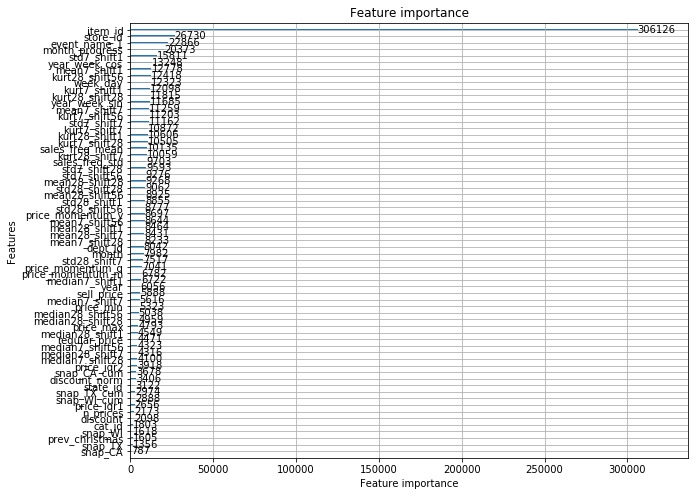

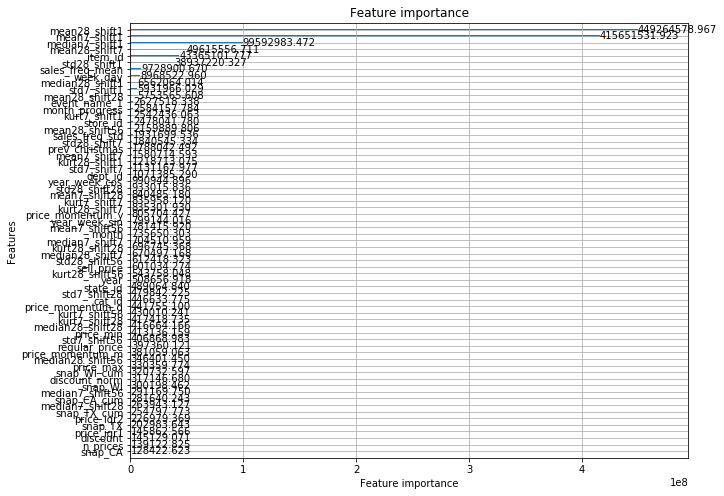

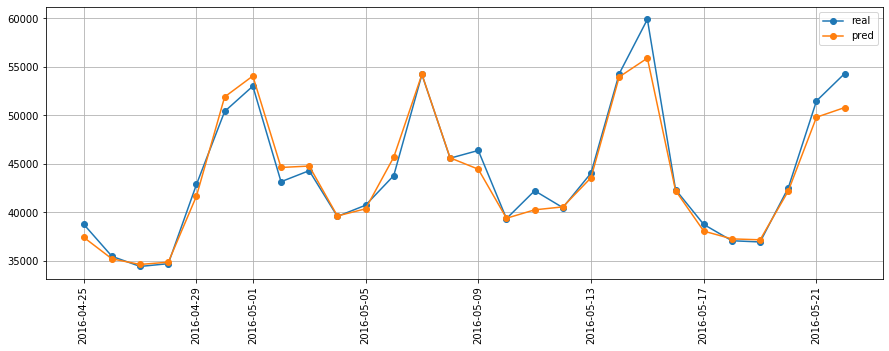

CPU times: user 8h 51min 55s, sys: 45min 52s, total: 9h 37min 48s
Wall time: 57min 27s


30228

In [11]:
%%time 

print("#"*100)
print(f" Validation period: {valid_period} ".center(100, "#"))
print("#"*100)

valid_start = valid_period[0]
valid_end = valid_period[1]
_train_data = data.query("ds < @valid_start").reset_index(drop=True)

print("Building the features")
tic = time.time()
model_level12 = LightGBMForecaster(**model_kwargs)
model_level12.prepare_features(train_data=_train_data)
model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
model_level12.train_features = reduce_mem_usage(model_level12.train_features)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

ts_id_in_train = model_level12.train_features.ts_id.unique()
valid_data = data.query("@valid_start <= ds <= @valid_end & ts_id in @ts_id_in_train")
evaluator = Evaluator(valid_data, weights_by_level, scales_by_level)

print("Fitting the model")
tic = time.time()
model_level12.fit()
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))

print("Predicting")
tic = time.time()
forecast = model_level12.predict(valid_data.drop("y", axis=1), recursive=True)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

wrmsse = evaluator.eval1._evaluate(forecast.y_pred.values)
wrmsseL12 = evaluator.eval2._evaluate(forecast.y_pred.values)
print("wrmsse:", wrmsse)
print("wrmsseL12:", wrmsseL12)
print(evaluator.eval1.errors_by_level)

mrg = (valid_data.groupby(["ds"])["y"].sum().reset_index()
       .merge(forecast.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
plt.plot_date(mrg.ds, mrg.y_pred, "o-", label="pred")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

gc.collect()

***
## training with early stopping

####################################################################################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.996995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6153
[LightGBM] [Info] Number of data points in the train set: 24364230, number of used features: 71
Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsseL12: 0.875242	valid_0's wrmsse: 1.11619
[50]	valid_0's wrmsseL12: 0.803201	valid_0's wrmsse: 0.664444
[75]	valid_0's wrmsseL12: 0.793149	valid_0's wrmsse: 0.55237
[100]	valid_0's wrmsseL12: 0.790699	valid_0's wrmsse: 0.520644
[125]	valid

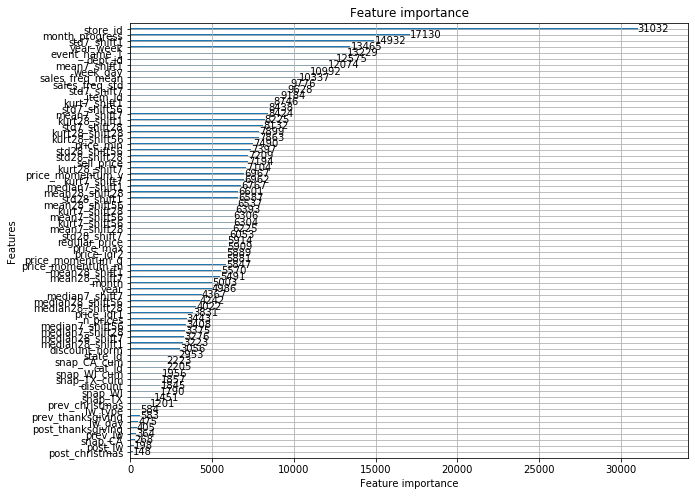

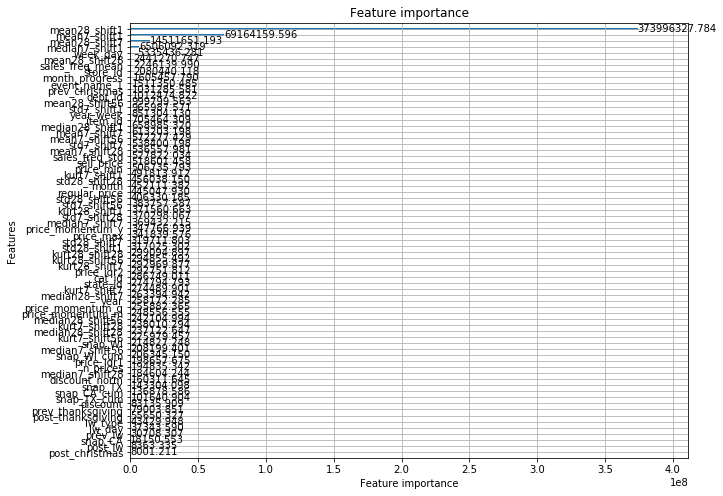

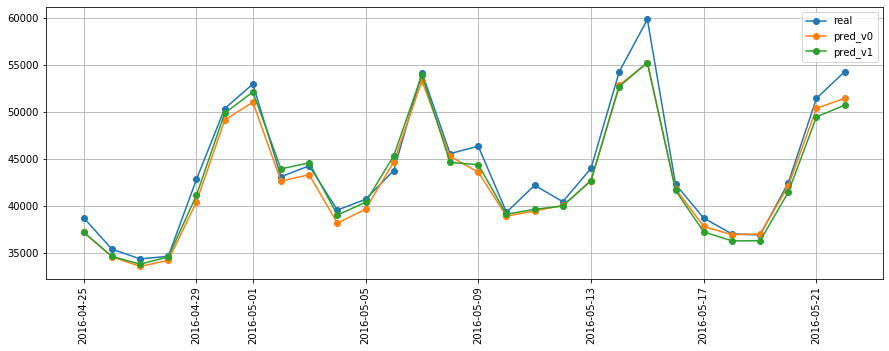

CPU times: user 7h 27min 44s, sys: 1h 15min 28s, total: 8h 43min 12s
Wall time: 1h 59min 20s


32876

In [10]:
%%time

print("#"*100)
print(f" Validation period: {valid_period} ".center(100, "#"))
print("#"*100)

valid_start = valid_period[0]
valid_end = valid_period[1]
_train_data = data.query("ds <= @valid_end").reset_index(drop=True)
_valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

model_level12 = LightGBMForecaster(**model_kwargs)
model_level12.prepare_features(train_data=_train_data, valid_index=_valid_index);
model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
model_level12.train_features = reduce_mem_usage(model_level12.train_features)
model_level12.valid_features = reduce_mem_usage(model_level12.valid_features)
ts_id_in_train = model_level12.train_features.ts_id.unique()
model_level12.valid_features = model_level12.valid_features.query("ts_id in @ts_id_in_train")

print("Fitting the model")
tic = time.time()
evaluator = Evaluator(model_level12.valid_features)
model_level12.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))

valid_dataframe = (model_level12.valid_features
                   .loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]]
                   .copy())
evaluator = WRMSSEEvaluator(valid_dataframe)

print("Predicting with ground thruth lagged values")
tic = time.time()
forecast_f4_v0 = (model_level12.valid_features
                  .loc[:, ["ds"]+model_level12.ts_uid_columns]
                  .assign(y_pred = model_level12.model.predict(model_level12.valid_features)))
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

wrmsse = evaluator._evaluate(forecast_f4_v0.y_pred.values)
print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)

print("Predicting with recursive approach")
tic = time.time()
valid_data = model_level12.valid_features.loc[:, model_level12.raw_train_columns].drop("y", axis=1)
forecast_f4_v1 = model_level12.predict(valid_data, recursive=True)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

wrmsse = evaluator._evaluate(forecast_f4_v1.y_pred.values)
print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)

mrg = (model_level12.valid_features.groupby(["ds"])["y"].sum().reset_index()
       .merge(forecast_f4_v0.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds")
       .merge(forecast_f4_v1.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
plt.plot_date(mrg.ds, mrg.y_pred_x, "o-", label="pred_v0")
plt.plot_date(mrg.ds, mrg.y_pred_y, "o-", label="pred_v1")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

gc.collect()

***

In [11]:
forecast = pd.read_csv("../output/forecast-f4.csv", parse_dates=["ds"])

***

In [12]:
mrg = pd.merge(data.query("ds <= '2016-05-22'").loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]],
               forecast,
               how="left", on=["ds","item_id","store_id"])

***
## Level 1

In [13]:
mrg_level1 = mrg.groupby(["ds"])[["y","y_pred"]].sum().reset_index()

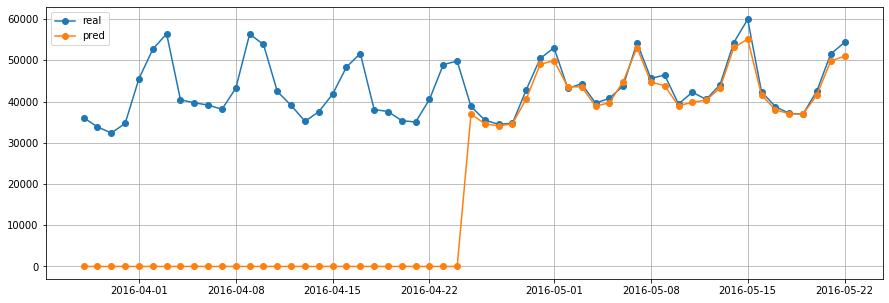

In [14]:
df = mrg_level1.query("ds >= '2016-03-28'")

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-", label="real")
plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
plt.grid()
plt.legend(loc="best")
plt.show()

In [15]:
predict_data = make_time_range("2011-04-24", "2016-05-22", "D")

In [16]:
import numpy as np
import pandas as pd
from supersmoother import SuperSmoother

class TrendEstimator():
    
    def __init__(self, primary_bandwidths, middle_bandwidth, final_bandwidth, alpha):
        self.primary_bandwidths = primary_bandwidths
        self.middle_bandwidth = middle_bandwidth
        self.final_bandwidth = final_bandwidth
        self.alpha = alpha
    
    def fit(self, data):
        min_date = data.ds.min()
        time_idx = (data.ds - min_date).apply(lambda x: x.days).values
        time_values = data.y.values
        
        # from bandwidths to spans
        kwargs = {
            "alpha":self.alpha,
            "primary_spans":self.primary_bandwidths/data.shape[0],
            "middle_span":self.middle_bandwidth/data.shape[0],
            "final_span":self.final_bandwidth/data.shape[0],   
        }
        trend_model = SuperSmoother(**kwargs)
        trend_model.fit(time_idx, time_values)
        
        self.min_date = min_date
        self.trend_model = trend_model
    
    def predict(self, data):
        time_idx = (data.ds - self.min_date).apply(lambda x: x.days).values
        trend = self.trend_model.predict(time_idx)
        return pd.DataFrame({"ds":data.ds, "trend":trend})

In [23]:
df = pd.concat([
    mrg_level1.query("ds < '2016-04-25'").loc[:, ["ds","y"]],
    mrg_level1.query("ds >= '2016-04-25'").loc[:, ["ds","y_pred"]].rename({"y_pred":"y"}, axis=1)],
    ignore_index=True)

trend_model1 = TrendEstimator(primary_bandwidths=np.arange(15, 34), middle_bandwidth=27, final_bandwidth=34, alpha=8)
trend_model1.fit(df)
trend1 = trend_model1.predict(predict_data)

In [24]:
df = mrg_level1.query("ds < '2016-04-25'").loc[:, ["ds","y"]]

trend_model2 = TrendEstimator(primary_bandwidths=np.arange(74, 77), middle_bandwidth=110, final_bandwidth=87, alpha=4)
trend_model2.fit(df)
trend2 = trend_model2.predict(predict_data)

In [25]:
_mrg_level1 = (mrg_level1
              .merge(trend1, on="ds")
              .merge(trend2, on="ds")
             )
_mrg_level1

,ds,y,y_pred,trend_x,trend_y
0,2011-04-24,24018.0,0.000000,23843.979084,24364.032739
1,2011-04-25,20004.0,0.000000,23799.350594,24357.168786
2,2011-04-26,18113.0,0.000000,23751.014413,24350.329597
3,2011-04-27,17929.0,0.000000,23706.597669,24344.284072
4,2011-04-28,18145.0,0.000000,23666.435731,24340.411777
...,...,...,...,...,...
1851,2016-05-18,37096.0,37005.744745,43948.800362,43580.377077
1852,2016-05-19,36963.0,36947.539296,44054.178634,43605.706476
1853,2016-05-20,42552.0,41560.034101,44159.548281,43631.035875
1854,2016-05-21,51518.0,49800.673944,44226.381130,43656.365274


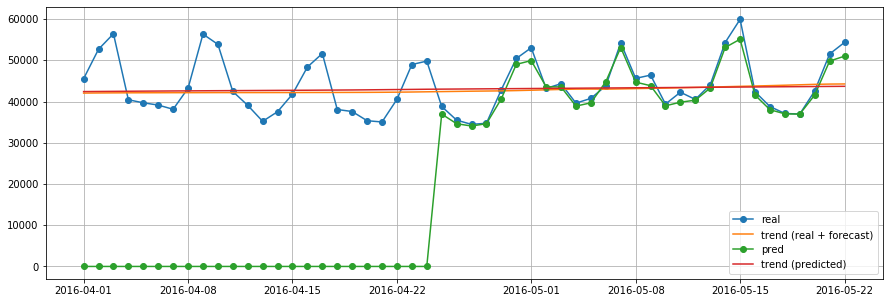

In [28]:
df = _mrg_level1.query("ds >= '2016-04-01'")

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-", label="real")
plt.plot_date(df.ds, df.trend_x, "-", label="trend (real + forecast)")
plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
plt.plot_date(df.ds, df.trend_y, "-", label="trend (predicted)")
plt.grid()
plt.legend(loc="best")
plt.show()

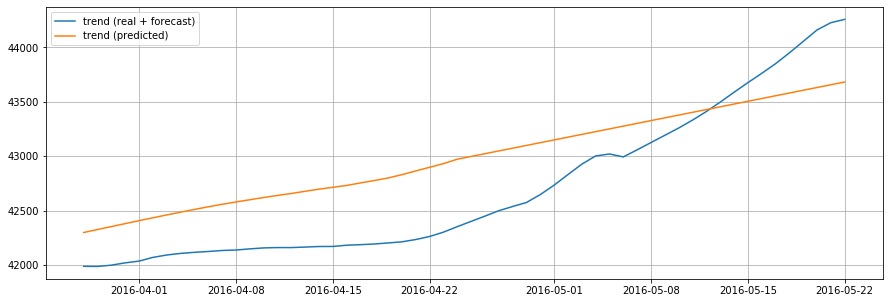

In [27]:
df = _mrg_level1.query("ds >= '2016-03-28'")

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.trend_x, "-", label="trend (real + forecast)")
plt.plot_date(df.ds, df.trend_y, "-", label="trend (predicted)")
plt.grid()
plt.legend(loc="best")
plt.show()

***

In [29]:
mrg_level3 = mrg.groupby(["ds","store_id"])[["y","y_pred"]].sum().reset_index()

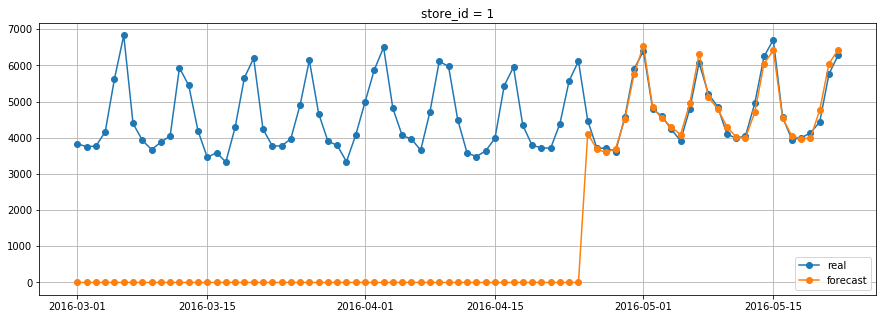

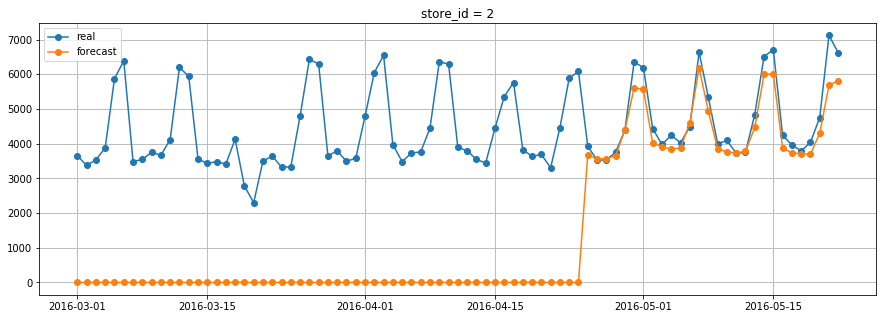

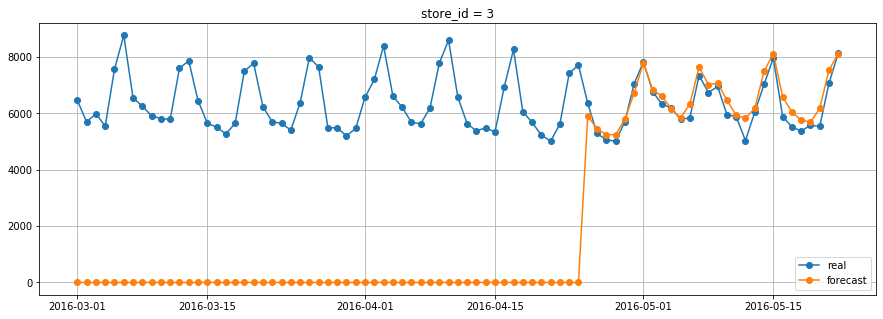

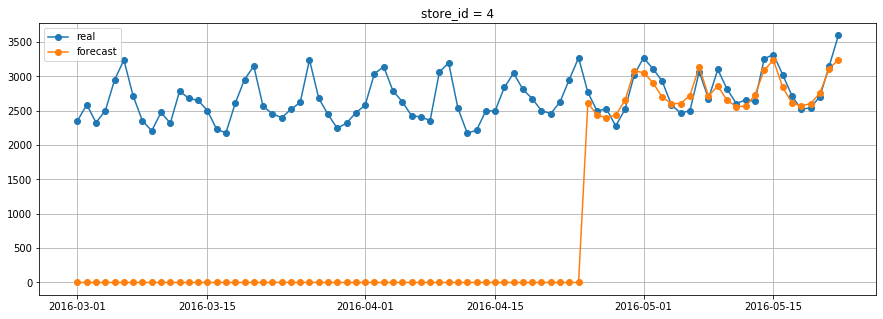

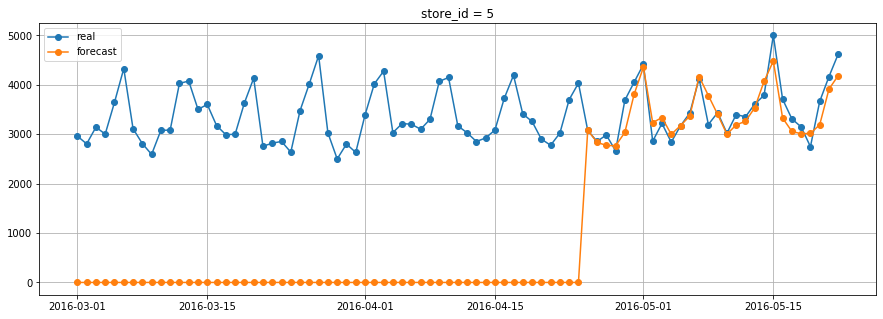

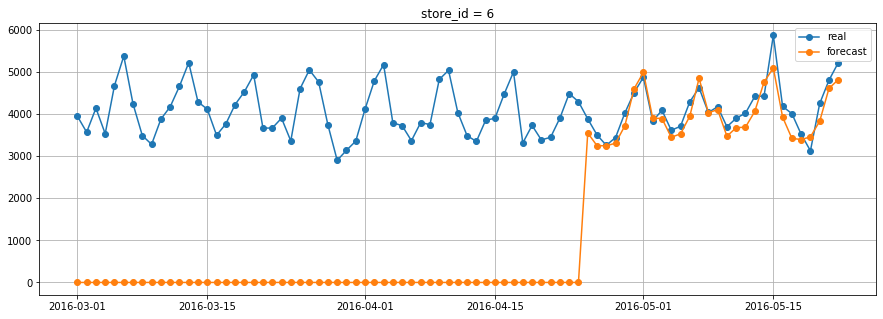

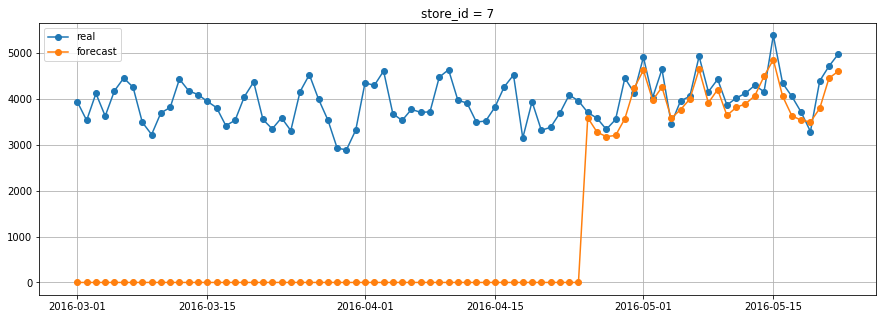

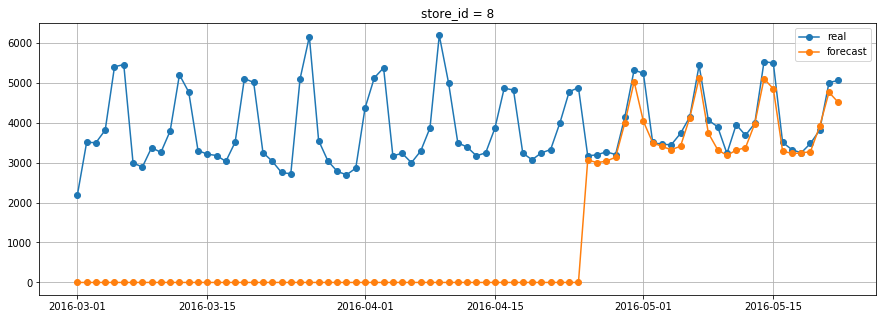

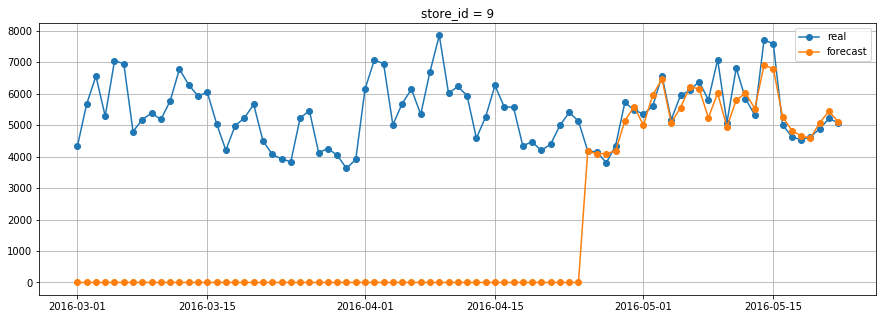

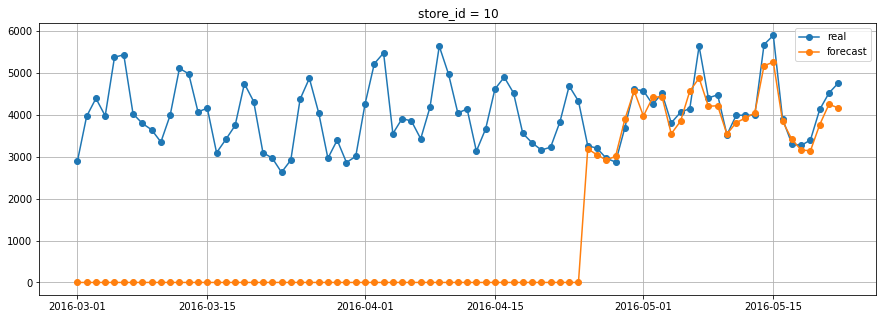

In [30]:
for store_id in mrg_level3.store_id.unique():
    df = mrg_level3.query("store_id == @store_id & ds >= '2016-03-01'")

    plt.figure(figsize=(15,5))
    plt.title(f"store_id = {store_id}")
    plt.plot_date(df.ds, df.y, "o-", label="real")
    plt.plot_date(df.ds, df.y_pred, "o-", label="forecast")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

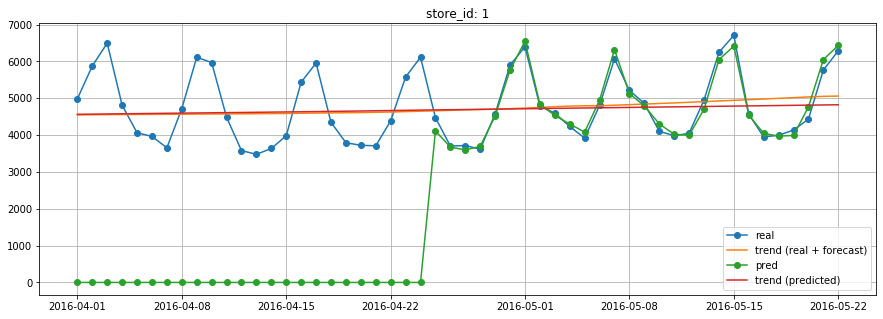

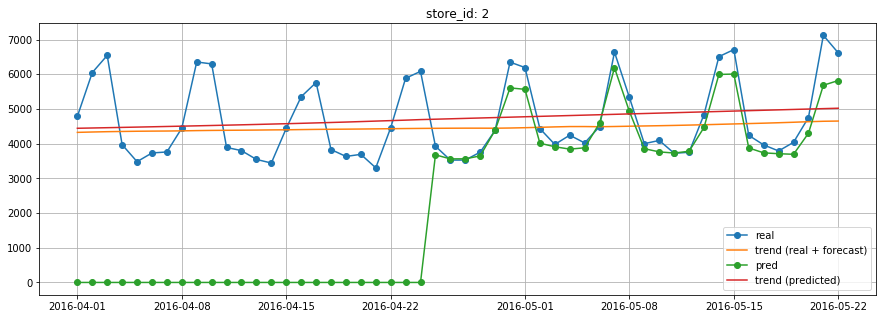

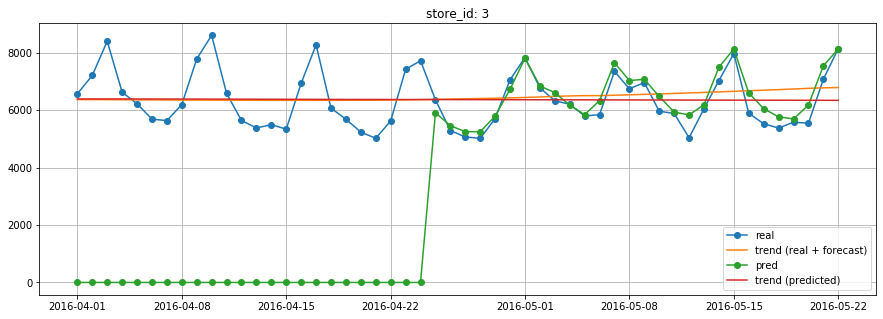

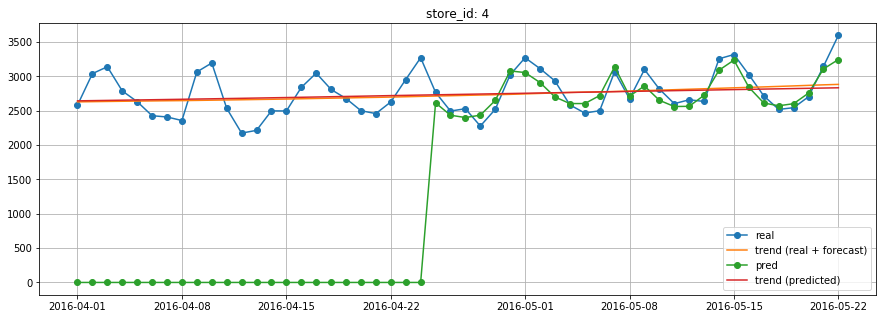

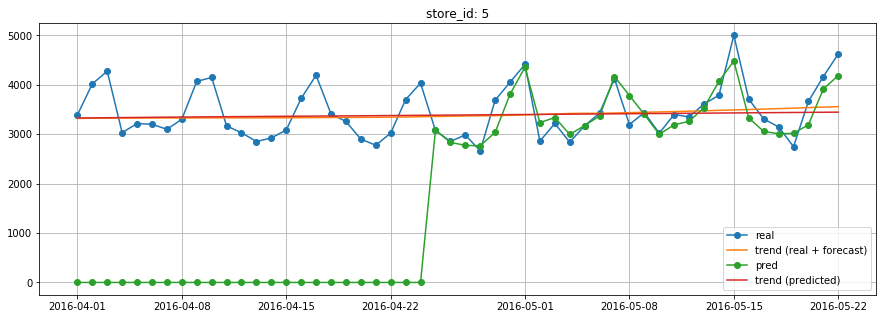

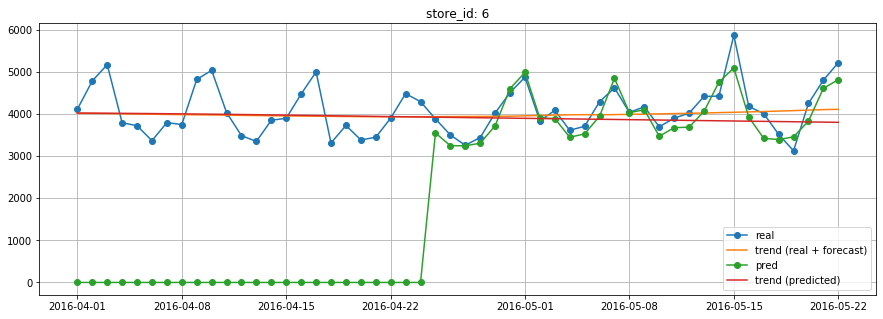

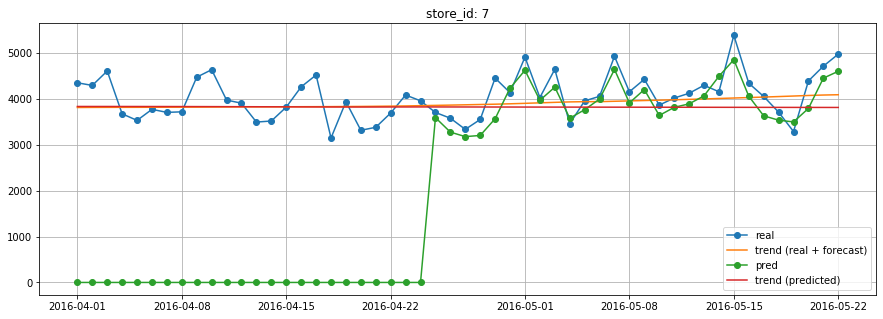

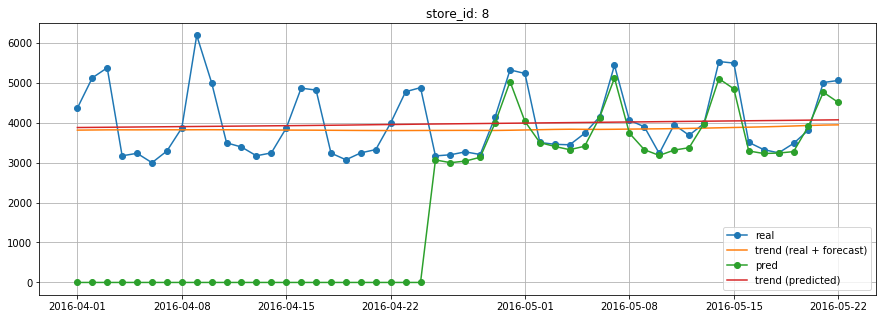

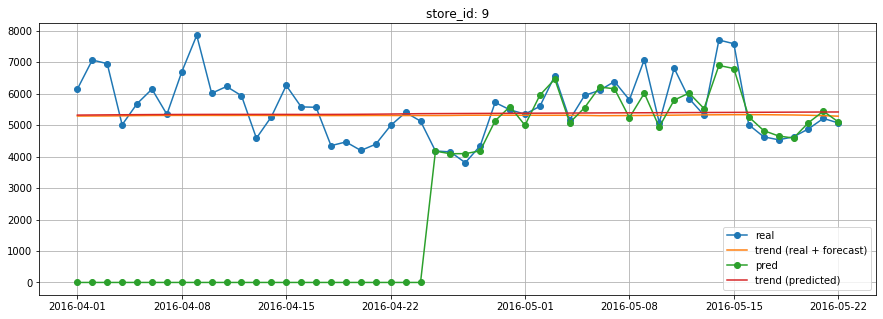

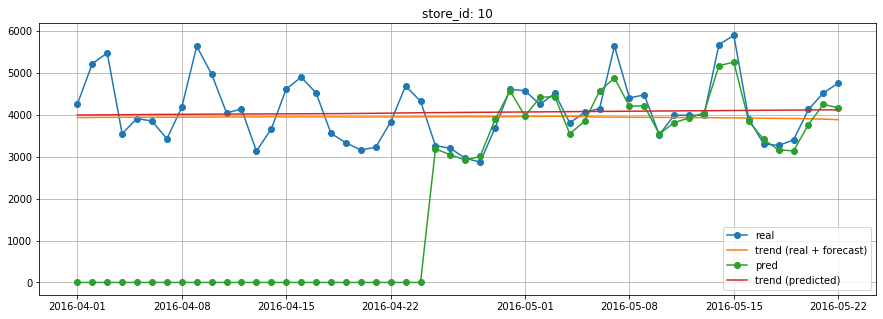

In [31]:
for store_id in mrg_level3.store_id.unique():
    df = pd.concat([
        mrg_level3.query("store_id == @store_id & ds < '2016-04-25'").loc[:, ["ds","y"]],
        mrg_level3.query("store_id == @store_id & ds >= '2016-04-25'").loc[:, ["ds","y_pred"]].rename({"y_pred":"y"}, axis=1)],
        ignore_index=True)

    trend_model1 = TrendEstimator(primary_bandwidths=np.arange(15, 34), 
                                  middle_bandwidth=27, 
                                  final_bandwidth=34, 
                                  alpha=8)
    trend_model1.fit(df)
    trend1 = trend_model1.predict(predict_data)
    
    df = mrg_level3.query("store_id == @store_id & ds < '2016-04-25'").loc[:, ["ds","y"]]

    trend_model2 = TrendEstimator(primary_bandwidths=np.arange(74, 77), 
                                  middle_bandwidth=110, 
                                  final_bandwidth=87, 
                                  alpha=4)
    trend_model2.fit(df)
    trend2 = trend_model2.predict(predict_data)
    
    _mrg_level3 = (mrg_level3.query("store_id == @store_id")
                  .merge(trend1, on="ds")
                  .merge(trend2, on="ds")
                 )
    
    df = _mrg_level3.query("ds >= '2016-04-01'")

    plt.figure(figsize=(15,5))
    plt.title(f"store_id: {store_id}")
    plt.plot_date(df.ds, df.y, "o-", label="real")
    plt.plot_date(df.ds, df.trend_x, "-", label="trend (real + forecast)")
    plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
    plt.plot_date(df.ds, df.trend_y, "-", label="trend (predicted)")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    